In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime, timedelta, date
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.tsa.ar_model import AutoReg


In [2]:
df = pd.read_csv("data/temp_data.txt", index_col=1, parse_dates = True)
df.index = pd.to_datetime(df.index)

In [3]:
df.rename(columns={' SOUID':'id', '   TG':'temp', ' Q_TG':'quality'}, inplace= True)
df.temp = df.temp / 10

In [4]:
df.dtypes

id           int64
temp       float64
quality      int64
dtype: object

In [5]:
df.describe()

,id,temp,quality
count,53507.000000,53507.000000,53507.000000
mean,119335.479844,5.720921,0.032818
std,8023.477558,61.325550,0.542349
min,111448.000000,-999.900000,0.000000
25%,111448.000000,3.300000,0.000000
50%,111448.000000,9.400000,0.000000
75%,127488.000000,15.700000,0.000000
max,128124.000000,30.500000,9.000000


There are no missing values, however it does seem like the minimum temperature does not make sense

In [6]:
df[df['quality'] == 9].value_counts()

id      temp    quality
127488  -999.9  9          195
dtype: int64

It looks like in any row with quality = 9 (data missing), the data for temperature has been filled in as -999

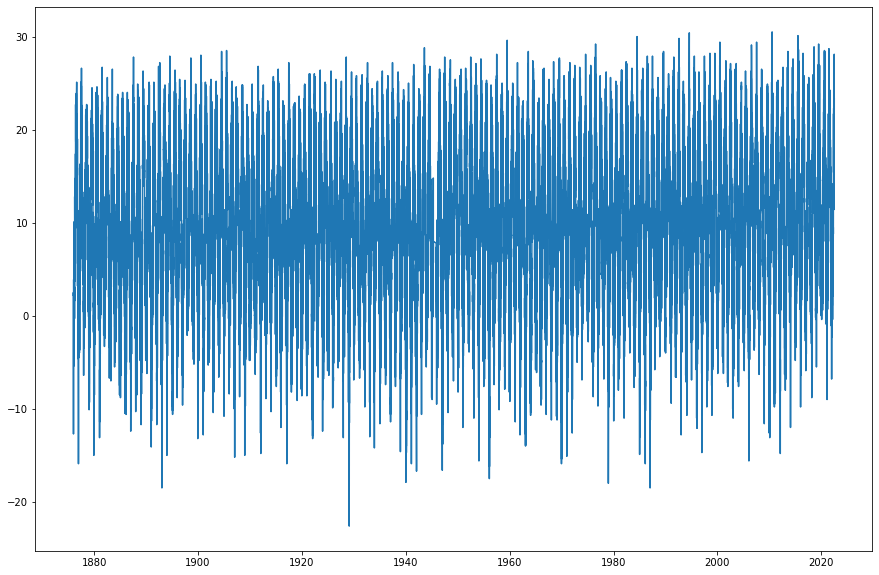

In [7]:
plt.figure(figsize=(15,10))
plt.plot(df.index[df['quality'] != 9], df['temp'][df['quality'] != 9])

In [8]:
def replace_missing_temp(date):
    date_one_year_ago = date - timedelta(days=365)
    date = pd.to_datetime(date)
    date_one_year_ago = pd.to_datetime(date_one_year_ago)
    #print(date_one_year_ago)

    if pd.to_datetime(date_one_year_ago) in df.index:
        df['temp'].loc[date] = df['temp'].loc[date_one_year_ago]
    else:
        print('Could NOT find date')
    
#replace_missing_temp(test_date)

index = df[df['quality'] == 9].index

for date in index:
    replace_missing_temp(date)
    
df

/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_55551/257645448.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'].loc[date] = df['temp'].loc[date_one_year_ago]


,id,temp,quality
DATE,,,
1876-01-01,127488,2.2,0
1876-01-02,127488,2.5,0
1876-01-03,127488,0.3,0
1876-01-04,127488,-5.8,0
1876-01-05,127488,-9.8,0
...,...,...,...
2022-06-26,111448,26.3,0
2022-06-27,111448,28.1,0
2022-06-28,111448,21.4,0


In [9]:
#df_by_month = df.resample('1M').mean()

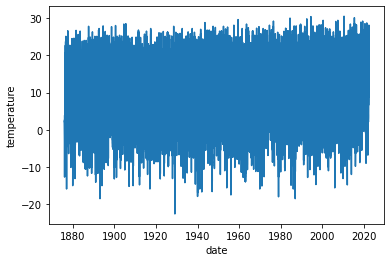

In [10]:
plt.plot(df.index, df['temp'])
plt.xlabel('date')
plt.ylabel('temperature');

In [11]:
df['timestep'] = list(range(len(df)))


In [12]:
df_train = df[df.index <= '2021-12-31']

X_train = df_train[['timestep']]
y_train = df_train['temp']



df_test = df[df.index > '2021-12-31']

X_test = df_test[['timestep']]
y_test = df_test['temp']


In [13]:
X_test

,timestep
DATE,
2022-01-01,53326
2022-01-02,53327
2022-01-03,53328
2022-01-04,53329
2022-01-05,53330
...,...
2022-06-26,53502
2022-06-27,53503
2022-06-28,53504


In [14]:
pipeline = Pipeline([
    ('model', LinearRegression())
])

In [15]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
#y_pred

In [16]:
pipeline.score(X_train, y_train)

0.004285644644674069

In [17]:
pipeline.score(X_test, y_test)

-0.000801375214910971

In [18]:
coefs = pipeline['model'].coef_
coefs

array([3.3507071e-05])

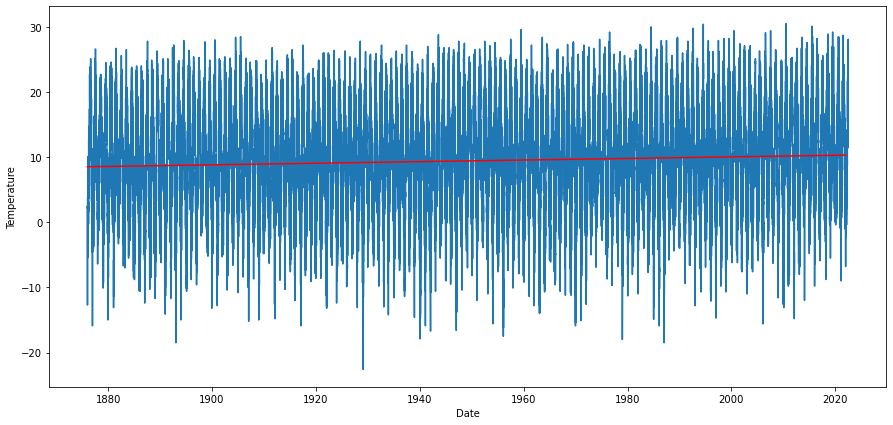

In [19]:
plt.figure(figsize=(15,7))
plt.plot(df.index, df.temp)
plt.plot(X_train.index, y_pred, color="red")
plt.xlabel('Date')
plt.ylabel('Temperature');

## Seasonality

In [20]:
#X_full = df.drop(columns=['temp'])
#y_full = df['temp']

In [21]:
#X_full

In [22]:
seasonal_dummies = pd.get_dummies(X_train.index.month,
                                  prefix='month').set_index(X_train.index)

X_train = X_train.join(seasonal_dummies)

In [23]:
df

,id,temp,quality,timestep
DATE,,,,
1876-01-01,127488,2.2,0,0
1876-01-02,127488,2.5,0,1
1876-01-03,127488,0.3,0,2
1876-01-04,127488,-5.8,0,3
1876-01-05,127488,-9.8,0,4
...,...,...,...,...
2022-06-26,111448,26.3,0,53502
2022-06-27,111448,28.1,0,53503
2022-06-28,111448,21.4,0,53504


In [24]:
#X = df_dummies.drop('temp', axis=1)
#y = df_dummies['temp']

#X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=12)

In [25]:
"""ts_split = TimeSeriesSplit(n_splits=5)
time_series_split = ts_split.split(X_train, y_train) """

'ts_split = TimeSeriesSplit(n_splits=5)\ntime_series_split = ts_split.split(X_train, y_train) '

In [26]:
m = LinearRegression()
m.fit(X_train, y_train)

LinearRegression()

In [27]:
"""result = cross_val_score(estimator=m, 
                         X=X_train, y=X_train,
                         cv=time_series_split)
result"""

'result = cross_val_score(estimator=m, \n                         X=X_train, y=X_train,\n                         cv=time_series_split)\nresult'

In [28]:
#result.mean()

In [29]:
X_train['seasonal'] = m.predict(X_train)

In [30]:
X_train

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal
DATE,,,,,,,,,,,,,,
1876-01-01,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.876637
1876-01-02,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.876604
1876-01-03,2,1,0,0,0,0,0,0,0,0,0,0,0,-0.876571
1876-01-04,3,1,0,0,0,0,0,0,0,0,0,0,0,-0.876538
1876-01-05,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.876505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,53321,0,0,0,0,0,0,0,0,0,0,0,1,2.232617
2021-12-28,53322,0,0,0,0,0,0,0,0,0,0,0,1,2.232650
2021-12-29,53323,0,0,0,0,0,0,0,0,0,0,0,1,2.232683


In [31]:
#pipeline.fit(X_train, y_train)

In [32]:
#X_train.head()

In [33]:
X_train.sort_index(inplace=True)


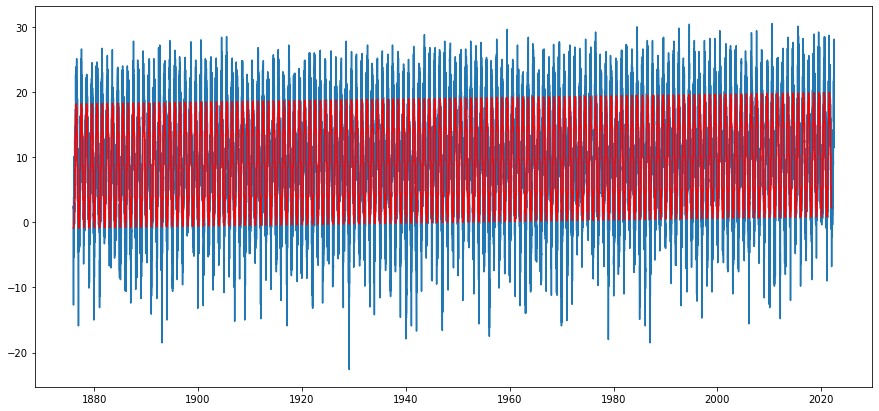

In [34]:
plt.figure(figsize=(15,7))
plt.plot(df.index, df.temp)
plt.plot(X_train.index, X_train.seasonal, color="red")
#plt.xlabel('Date')
#plt.ylabel('Temperature');

In [35]:
df_with_seasonal = X_train.join(y_train)
df_with_seasonal

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal,temp
DATE,,,,,,,,,,,,,,,
1876-01-01,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.876637,2.2
1876-01-02,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.876604,2.5
1876-01-03,2,1,0,0,0,0,0,0,0,0,0,0,0,-0.876571,0.3
1876-01-04,3,1,0,0,0,0,0,0,0,0,0,0,0,-0.876538,-5.8
1876-01-05,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.876505,-9.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,53321,0,0,0,0,0,0,0,0,0,0,0,1,2.232617,-3.9
2021-12-28,53322,0,0,0,0,0,0,0,0,0,0,0,1,2.232650,-0.5
2021-12-29,53323,0,0,0,0,0,0,0,0,0,0,0,1,2.232683,4.5


In [36]:
df_with_seasonal['remainder'] = df_with_seasonal['temp'] - df_with_seasonal['seasonal']

In [37]:
df_with_seasonal

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal,temp,remainder
DATE,,,,,,,,,,,,,,,,
1876-01-01,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.876637,2.2,3.076637
1876-01-02,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.876604,2.5,3.376604
1876-01-03,2,1,0,0,0,0,0,0,0,0,0,0,0,-0.876571,0.3,1.176571
1876-01-04,3,1,0,0,0,0,0,0,0,0,0,0,0,-0.876538,-5.8,-4.923462
1876-01-05,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.876505,-9.8,-8.923495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,53321,0,0,0,0,0,0,0,0,0,0,0,1,2.232617,-3.9,-6.132617
2021-12-28,53322,0,0,0,0,0,0,0,0,0,0,0,1,2.232650,-0.5,-2.732650
2021-12-29,53323,0,0,0,0,0,0,0,0,0,0,0,1,2.232683,4.5,2.267317


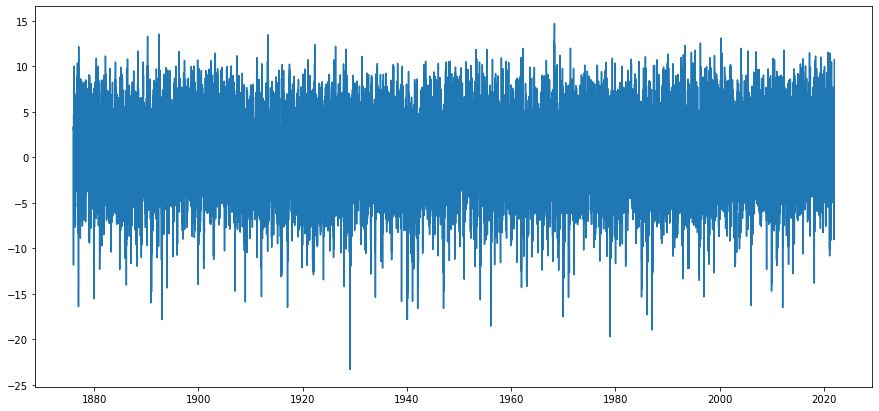

In [38]:
plt.figure(figsize=(15,7))
plt.plot(df_with_seasonal.index, df_with_seasonal['remainder'])

In [39]:
from statsmodels.tsa.ar_model import ar_select_order

selected_order = ar_select_order(df_with_seasonal['remainder'], maxlag=12)
lag_list = selected_order.ar_lags
lag_list

/Users/em/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/em/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[1, 2, 3, 4]

In [40]:
def add_lag_column(dataframe, list_of_lags):
    for number in list_of_lags:
        dataframe['lag' + str(number)] = dataframe['remainder'].shift(number)
        dataframe.dropna(inplace=True)
    return dataframe

add_lag_column(df_with_seasonal, lag_list)

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal,temp,remainder,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,,,,,
1876-01-11,10,1,0,0,0,0,0,0,0,0,0,0,0,-0.876308,-6.2,-5.323692,-8.023659,-11.823626,-8.023593,-5.723560
1876-01-12,11,1,0,0,0,0,0,0,0,0,0,0,0,-0.876275,-4.6,-3.723725,-5.323692,-8.023659,-11.823626,-8.023593
1876-01-13,12,1,0,0,0,0,0,0,0,0,0,0,0,-0.876243,-3.5,-2.623757,-3.723725,-5.323692,-8.023659,-11.823626
1876-01-14,13,1,0,0,0,0,0,0,0,0,0,0,0,-0.876210,-3.6,-2.723790,-2.623757,-3.723725,-5.323692,-8.023659
1876-01-15,14,1,0,0,0,0,0,0,0,0,0,0,0,-0.876177,-3.1,-2.223823,-2.723790,-2.623757,-3.723725,-5.323692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,53321,0,0,0,0,0,0,0,0,0,0,0,1,2.232617,-3.9,-6.132617,-9.032584,-7.732551,-0.232519,-3.332486
2021-12-28,53322,0,0,0,0,0,0,0,0,0,0,0,1,2.232650,-0.5,-2.732650,-6.132617,-9.032584,-7.732551,-0.232519
2021-12-29,53323,0,0,0,0,0,0,0,0,0,0,0,1,2.232683,4.5,2.267317,-2.732650,-6.132617,-9.032584,-7.732551


In [41]:
X_train = df_with_seasonal.drop(columns=['temp', 'seasonal', 'remainder'])
y_train = df_with_seasonal['temp']

In [42]:
X_train

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,,
1876-01-11,10,1,0,0,0,0,0,0,0,0,0,0,0,-8.023659,-11.823626,-8.023593,-5.723560
1876-01-12,11,1,0,0,0,0,0,0,0,0,0,0,0,-5.323692,-8.023659,-11.823626,-8.023593
1876-01-13,12,1,0,0,0,0,0,0,0,0,0,0,0,-3.723725,-5.323692,-8.023659,-11.823626
1876-01-14,13,1,0,0,0,0,0,0,0,0,0,0,0,-2.623757,-3.723725,-5.323692,-8.023659
1876-01-15,14,1,0,0,0,0,0,0,0,0,0,0,0,-2.723790,-2.623757,-3.723725,-5.323692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,53321,0,0,0,0,0,0,0,0,0,0,0,1,-9.032584,-7.732551,-0.232519,-3.332486
2021-12-28,53322,0,0,0,0,0,0,0,0,0,0,0,1,-6.132617,-9.032584,-7.732551,-0.232519
2021-12-29,53323,0,0,0,0,0,0,0,0,0,0,0,1,-2.732650,-6.132617,-9.032584,-7.732551


In [43]:
m = LinearRegression()
m.fit(X_train, y_train)

LinearRegression()

In [44]:
df_with_seasonal['full_predictions'] = m.predict(X_train)

In [45]:
df_with_seasonal.sort_index()

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,month_11,month_12,seasonal,temp,remainder,lag1,lag2,lag3,lag4,full_predictions
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-11,10,1,0,0,0,0,0,0,0,0,...,0,0,-0.876308,-6.2,-5.323692,-8.023659,-11.823626,-8.023593,-5.723560,-6.464476
1876-01-12,11,1,0,0,0,0,0,0,0,0,...,0,0,-0.876275,-4.6,-3.723725,-5.323692,-8.023659,-11.823626,-8.023593,-4.958703
1876-01-13,12,1,0,0,0,0,0,0,0,0,...,0,0,-0.876243,-3.5,-2.623757,-3.723725,-5.323692,-8.023659,-11.823626,-3.868308
1876-01-14,13,1,0,0,0,0,0,0,0,0,...,0,0,-0.876210,-3.6,-2.723790,-2.623757,-3.723725,-5.323692,-8.023659,-2.957675
1876-01-15,14,1,0,0,0,0,0,0,0,0,...,0,0,-0.876177,-3.1,-2.223823,-2.723790,-2.623757,-3.723725,-5.323692,-3.130629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,53321,0,0,0,0,0,0,0,0,0,...,0,1,2.232617,-3.9,-6.132617,-9.032584,-7.732551,-0.232519,-3.332486,-4.622779
2021-12-28,53322,0,0,0,0,0,0,0,0,0,...,0,1,2.232650,-0.5,-2.732650,-6.132617,-9.032584,-7.732551,-0.232519,-2.058912
2021-12-29,53323,0,0,0,0,0,0,0,0,0,...,0,1,2.232683,4.5,2.267317,-2.732650,-6.132617,-9.032584,-7.732551,0.311111


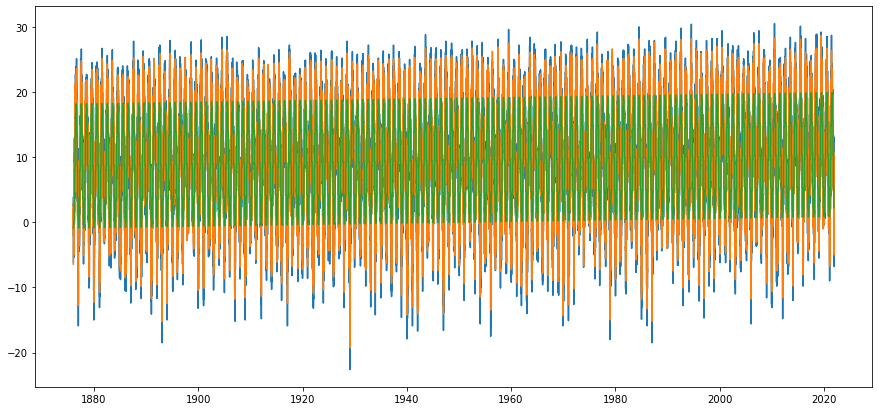

In [46]:
plt.figure(figsize=(15,7))
plt.plot(df_with_seasonal.index, df_with_seasonal.temp)
plt.plot(df_with_seasonal.index, df_with_seasonal['full_predictions'])
plt.plot(df_with_seasonal.index, df_with_seasonal['seasonal'])

In [47]:
df_by_month= df_with_seasonal.resample('1Y').mean()
df_by_month

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,month_11,month_12,seasonal,temp,remainder,lag1,lag2,lag3,lag4,full_predictions
DATE,,,,,,,,,,,,,,,,,,,,,
1876-12-31,187.5,0.058989,0.081461,0.087079,0.084270,0.087079,0.084270,0.087079,0.087079,0.084270,...,0.084270,0.087079,8.794256,9.737640,0.943384,0.903129,0.853884,0.818966,0.805395,9.516841
1877-12-31,548.0,0.084932,0.076712,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,0.082192,...,0.082192,0.084932,8.565187,9.727945,1.162758,1.171284,1.180084,1.194911,1.193848,9.498691
1878-12-31,913.0,0.084932,0.076712,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,0.082192,...,0.082192,0.084932,8.577180,10.236712,1.659532,1.643400,1.639598,1.630315,1.618567,9.886345
1879-12-31,1278.0,0.084932,0.076712,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,0.082192,...,0.082192,0.084932,8.589173,8.180548,-0.408625,-0.390236,-0.388012,-0.388801,-0.366028,8.279158
1880-12-31,1643.5,0.084699,0.079235,0.084699,0.081967,0.084699,0.081967,0.084699,0.084699,0.081967,...,0.081967,0.084699,8.578033,9.805191,1.227159,1.225279,1.216569,1.204306,1.188765,9.554617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,51682.0,0.084932,0.076712,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,0.082192,...,0.082192,0.084932,10.245315,10.712055,0.466740,0.442937,0.436395,0.443003,0.451255,10.599585
2018-12-31,52047.0,0.084932,0.076712,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,0.082192,...,0.082192,0.084932,10.257308,11.755616,1.498309,1.508479,1.498648,1.486900,1.478440,11.459014
2019-12-31,52412.0,0.084932,0.076712,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,0.082192,...,0.082192,0.084932,10.269301,11.824384,1.555083,1.554568,1.559532,1.576003,1.589461,11.508250


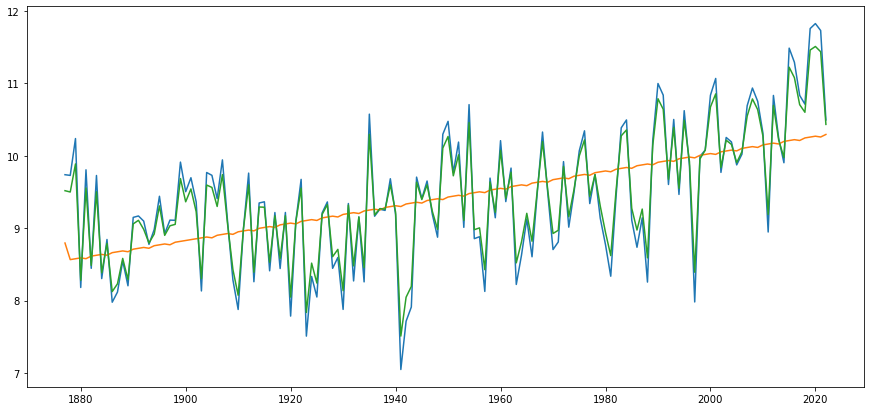

In [48]:
plt.figure(figsize=(15,7))
plt.plot(df_by_month.index, df_by_month.temp)
plt.plot(df_by_month.index, df_by_month['seasonal'])
plt.plot(df_by_month.index, df_by_month['full_predictions'])